In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
from colorama import Fore, Back, Style
import sympy as sym
import tabulate

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

### Problem 6 (CLO-3)

In [2]:
class PropagationSimulator:
    """
    A class to simulate path loss propagation.
    """

    def __init__(self, distance_arr, frequency, d0, alpha, N, sigma):
        """
        Constructs all the necessary attributes for the PropagationSimulator object.
        """
        self.distance_arr = distance_arr
        self.frequency = frequency
        self.alpha = alpha
        self.N = N
        self.sigma = sigma
        self.lambda_ = 3e8 / frequency
        self.d0 = d0
        self.d0_loss = 20 * np.log10(4 * np.pi * self.d0 / self.lambda_)

        # Required assertion as per question
        assert np.all(distance_arr >= d0), "All distances must be greater than or equal to d0."

        self.path_loss_arr = np.zeros((len(self.distance_arr), self.N))

        for i, distance in enumerate(self.distance_arr):
            for j in range(self.N):
                self.path_loss_arr[i, j] = self.log_distance(
                    distance, self.alpha, self.sigma
                )

    def log_distance(self, distance, alpha, sigma=None):
        """Log distance path loss model.

        Args:
            distance: Distance between transmitter and receiver.
            alpha: Path loss exponent.
            sigma: Shadow fading standard deviation.

        Returns:
            loss: Path loss in dB.
        """

        loss = self.d0_loss + 10 * alpha * np.log10(distance / self.d0)
        if sigma is not None:
            loss += np.random.normal(0, sigma, np.shape(loss))

        return loss

    def plot_scatter(self):
        """
        Plots a scatter plot of the path loss.
        """

        plt.figure(figsize=(6, 4))
        plt.scatter(
            np.repeat(self.distance_arr, self.N), self.path_loss_arr, s=3, c="black"
        )
        plt.scatter(
            self.distance_arr,
            np.mean(self.path_loss_arr, axis=1),
            s=50,
            marker="x",
            c="red",
        )
        plt.xlabel("Distance [m]")
        plt.ylabel("Path loss [dB]")
        plt.legend(["Samples", "Mean"])
        plt.title("Log-Distance Path Loss with Shadowing")
        plt.grid(alpha=0.35)
        plt.show()

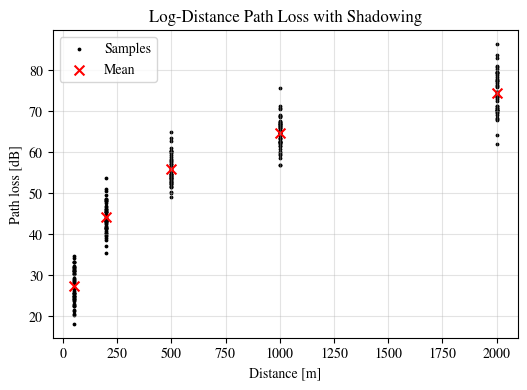

In [3]:
distance_arr = np.array([50, 200, 500, 1000, 2000])
frequency = 10e6
d0 = 50  # close-in reference distance
PL_d0 = 20 * np.log10(4 * np.pi * d0 / (3e8 / frequency))
alpha = 3  # path loss exponent
N = 50  # number of samples
sigma = 4  # shadow fading standard deviation
lambda_ = 3e8 / frequency

simulator = PropagationSimulator(distance_arr, frequency, d0, alpha, N, sigma)
simulator.plot_scatter()

In [4]:
# PL_d0 = 26.42
# n_ref = 4
# sigma_ref = 4
# distance = np.array([100, 200, 600, 1800, 4000])
# # PL_ref = np.array([34.59, 42.97, 58.48, 78.37, 91.913])
# PL_ref = PL_d0 + (
#     10 * n_ref * np.log10(distance / d0) + np.random.normal(0, sigma_ref, len(distance))
# )
# d0 = 100

# sym_n = sym.Symbol("n")
# PLd0 = PL_d0
# PLd1 = PL_d0 + 10 * sym_n * np.log10(distance[1] / d0)
# PLd2 = PL_d0 + 10 * sym_n * np.log10(distance[2] / d0)
# PLd3 = PL_d0 + 10 * sym_n * np.log10(distance[3] / d0)
# PLd4 = PL_d0 + 10 * sym_n * np.log10(distance[4] / d0)

# cost = np.sum((PL_ref - np.array([PLd0, PLd1, PLd2, PLd3, PLd4])) ** 2)
# dcost = sym.diff(cost, sym_n)
# n = sym.solve(dcost, sym_n)[0]
# print("n = ", n)

# print("Cost =", cost.evalf(subs={sym_n: n}))
# print("sigma =", sym.sqrt(cost.evalf(subs={sym_n: n}) / len(distance)))

In [5]:
sym_alpha = sym.Symbol("alpha")

# alpha is sufficient to compute a biased estimate of sigma
# path_loss_ref = simulator.log_distance(distance_arr, alpha, sigma)
path_loss_ref = np.array([27.86, 40.46, 63.40, 65.61, 71.05])
table = []
for i in range(len(distance_arr)):
    table.append([distance_arr[i], path_loss_ref[i]])
print(
    tabulate.tabulate(
        table, headers=["Distance [m]", "Path Loss [dB]"], tablefmt="fancy_grid"
    )
)

estimate = simulator.log_distance(distance_arr, sym_alpha)

def compute_MSE(path_loss_ref, estimate):
    mse = np.sum((path_loss_ref - estimate) ** 2)
    return mse

print("")
for i in range(len(distance_arr)):
    print(f"PL'({distance_arr[i]}m) = {estimate[i]}")


# symbolic differentiation of MSE w.r.t. alpha
MSE = compute_MSE(path_loss_ref, estimate)
print(f"\nMSE = {sym.simplify(compute_MSE(path_loss_ref, estimate))}")

dMSE = sym.diff(MSE, sym_alpha)
print(f"d_MSE/d_alpha = {sym.simplify(dMSE)}")

alpha_prime = sym.solve(dMSE, sym_alpha)[0]  # solve for alpha

# biased estimate of sigma
eval_MSE = MSE.evalf(subs={sym_alpha: alpha_prime})

# unbiased estimate of sigma
sigma_sqrd_prime = eval_MSE / len(distance_arr)
sigma_prime = sym.sqrt(sigma_sqrd_prime)

print("\nPLE Estimate =", alpha_prime)
print("Sigma Estimate =", sigma_prime)

╒════════════════╤══════════════════╕
│   Distance [m] │   Path Loss [dB] │
╞════════════════╪══════════════════╡
│             50 │            27.86 │
├────────────────┼──────────────────┤
│            200 │            40.46 │
├────────────────┼──────────────────┤
│            500 │            63.4  │
├────────────────┼──────────────────┤
│           1000 │            65.61 │
├────────────────┼──────────────────┤
│           2000 │            71.05 │
╘════════════════╧══════════════════╛

PL'(50m) = 26.4211722727691
PL'(200m) = 6.02059991327962*alpha + 26.4211722727691
PL'(500m) = 10.0*alpha + 26.4211722727691
PL'(1000m) = 13.0102999566398*alpha + 26.4211722727691
PL'(2000m) = 16.0205999132796*alpha + 26.4211722727691

MSE = 562.1751498589*alpha**2 - 3358.29887913286*alpha + 5094.08909220518
d_MSE/d_alpha = 1124.3502997178*alpha - 3358.29887913286

PLE Estimate = 2.98687951608654
Sigma Estimate = 3.96666173793586


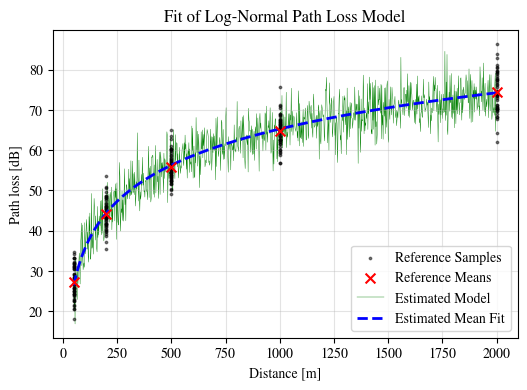

In [7]:
plt.figure(figsize=(6, 4))
plt.scatter(
    np.repeat(distance_arr, 50),
    simulator.path_loss_arr,
    s=3,
    alpha=0.5,
    c="black",
    zorder=10,
)
plt.scatter(
    distance_arr,
    np.mean(simulator.path_loss_arr, axis=1),
    s=50,
    marker="x",
    c="red",
    zorder=20,
)
d = np.linspace(d0, max(distance_arr), 1000)
est_fit = simulator.log_distance(d, alpha_prime, sigma_prime)
plt.plot(d, est_fit, "-", color="g", zorder=0, linewidth=0.3)
# estimation of log distance path loss reduces it to a non-random function
# i.e., E[X_o] = 0, where X_o is the shadow fading random variable
mean_est_fit = simulator.log_distance(d, alpha_prime)
plt.plot(d, mean_est_fit, "--", color="b", zorder=15, linewidth=2)

plt.xlabel("Distance [m]")
plt.ylabel("Path loss [dB]")
plt.legend(["Reference Samples", "Reference Means", "Estimated Model", "Estimated Mean Fit"])
plt.grid(alpha=0.35)
plt.title("Fit of Log-Normal Path Loss Model")
plt.show()